In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact, yeojohnson
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, pearsonr
from sklearn.linear_model import LinearRegression

# GWAS results from Encore - Old 

- Ran 2 analyses:
    1. Response variable = total passenger mutations; covariates = sex, age, PCs 1-10; variant filter = MAF > 0.1%
    2. Response variable = pacer_covadj_int; covariates = PCs 1-10; variant filter = MAF > 0.1%


- Model: Fast linear mixed model with kinship adjustment (saige-qt)

- Goal: To determine germline mutations associated with higher fitness (# of passenger mutations) among patients with mCAs

In [2]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/adc7c434-output.filtered.001 .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/adc7c434-output.filtered.001...
/ [1 files][  8.0 MiB/  8.0 MiB]                                                
Operation completed over 1 objects/8.0 MiB.                                      


In [3]:
# gwas_results_totpassmut_df = pd.read_csv('adc7c434-output.filtered.001', sep='\t')

In [4]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/a9b9a820-output.filtered.001 .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/a9b9a820-output.filtered.001...
/ [1 files][ 10.6 MiB/ 10.6 MiB]                                                
Operation completed over 1 objects/10.6 MiB.                                     


In [5]:
# gwas_results_pacerint_df = pd.read_csv('a9b9a820-output.filtered.001', sep='\t')

# GWAS results from Encore - New

- Response variable = total passenger mutations; covariates = sex, age, CHIP status, clonal fraction, PCs 1-10, status; variant filter = MAF > 0.1%

- Model: Fast linear mixed model with kinship adjustment (saige-qt)

- Goal: To determine germline mutations associated with higher fitness (# of passenger mutations) among patients with mCAs

In [2]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/54283d8c-output.filtered.001 .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/54283d8c-output.filtered.001...
/ [1 files][  4.6 MiB/  4.6 MiB]                                                
Operation completed over 1 objects/4.6 MiB.                                      


In [3]:
gwas_results_totpassmut_df = pd.read_csv('54283d8c-output.filtered.001', sep='\t')

## Excluding chrX

In [5]:
def exclude_chrX(df):
    print(len(df)-len(df[df['CHR']!='chrX']))
    return df[df['CHR']!='chrX']

In [6]:
gwas_results_pacerint_df = exclude_chrX(gwas_results_totpassmut_df)

1748


In [8]:
def manhattanplot(df):
    df['-logp'] = - np.log(df['p.value'])
    running_pos = 0
    cumulative_pos = []
    for chrom, group_df in df.groupby('CHR'):  
        cumulative_pos.append(group_df['POS'] + running_pos)
        running_pos += group_df['POS'].max()
    df['cumulative_pos'] = pd.concat(cumulative_pos)
    df['SNP number'] = df.index
    g = sns.relplot(
        data = df,
        x = 'cumulative_pos',
        y = '-logp',
        aspect = 4,
        hue = 'CHR',
        palette = 'Set1',
        linewidth=0,
        s=6,
        legend=None
    )    
    g.ax.set_ylabel('-log(p)', fontsize=20)
    g.ax.set_xlabel('Chromosome', fontsize=20)
    g.ax.set_xticks(df.groupby('CHR')['cumulative_pos'].median())
    g.ax.set_xticklabels(df['CHR'].str.replace("chr", "").unique(), fontsize=12)
    g.fig.suptitle('Manhattan Plot for GWAS of PACER among pts with mCAs', fontsize=30)
    g.fig.set_size_inches(18.5, 10.5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

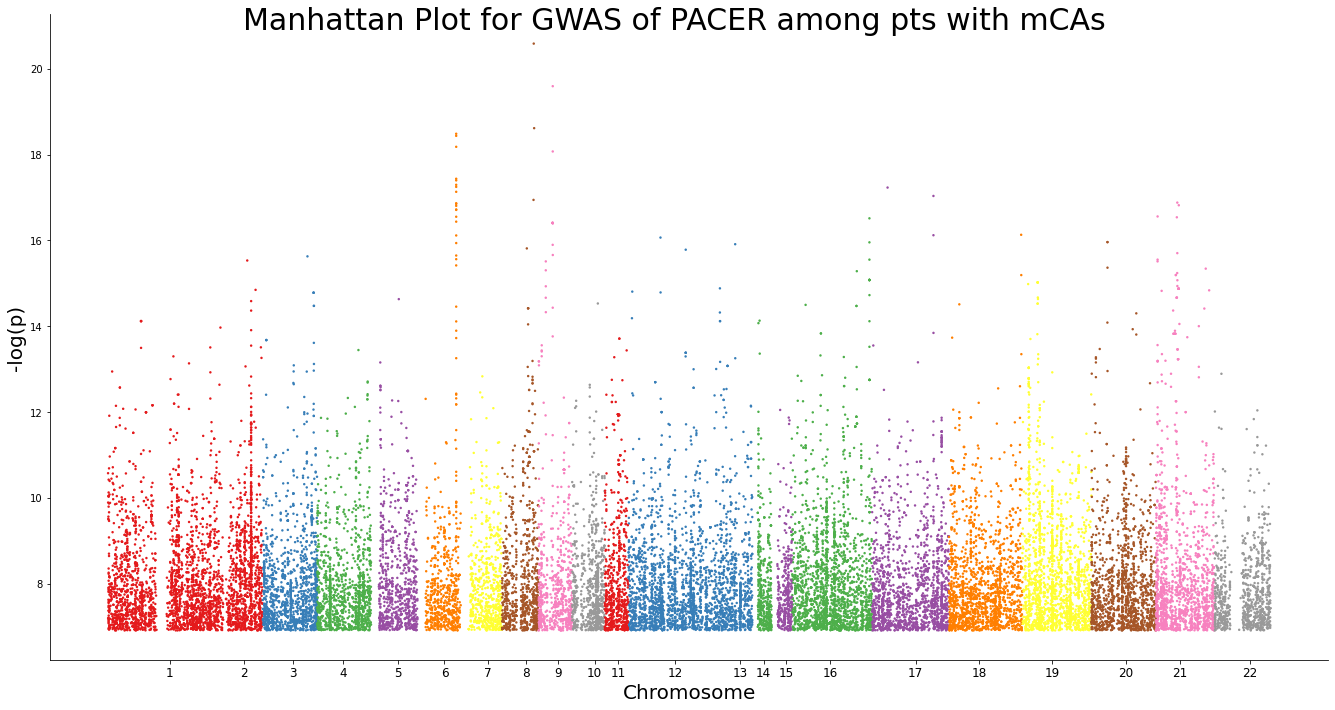

In [10]:
manhattanplot(gwas_results_totpassmut_df) #cov-adjusted during GWAS

In [11]:
gwas_results_totpassmut_df.sort_values('p.value', ascending = True)

,CHR,POS,SNPID,Allele1,Allele2,AC_Allele2,AF_Allele2,imputationInfo,N,BETA,SE,Tstat,p.value,varT,varTstar,-logp,cumulative_pos,SNP number
23080,chr16,78392107,rs373696525,C,T,21,0.001503,1,6984,1.131987,0.185935,32.743215,1.142627e-09,28.925436,19.958369,20.589936,1051181834,23080
23553,chr17,35394667,rs894251982,G,A,26,0.001861,1,6984,-0.992241,0.167410,-35.404149,3.084983e-09,35.680987,24.619656,19.596720,1098084866,23553
23101,chr16,79426797,rs771148700,G,A,15,0.001074,1,6984,1.301518,0.225795,25.528387,8.206099e-09,19.614321,13.533758,18.618388,1052216524,23101
21628,chr14,95713905,rs1122138,C,A,2950,0.211197,1,6984,-0.102036,0.017770,-323.143000,9.348600e-09,3166.952485,2185.177273,18.488039,859847458,21628
21627,chr14,95711986,rs2296312,T,C,2964,0.212199,1,6984,-0.101648,0.017728,-323.447042,9.813428e-09,3182.018887,2195.572996,18.439514,859845539,21627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11134,chr6,81111062,rs78209472,C,T,86,0.006157,1,6984,0.301336,0.091576,35.932680,9.998647e-04,119.244489,82.277947,6.907891,2337842625,11134
17234,chr10,120118515,rs149810661,C,T,29,0.002076,1,6984,-0.512224,0.155665,-21.138763,9.998819e-04,41.268580,28.475061,6.907873,368958050,17234
16302,chr10,58854537,rs7923069,G,T,1666,0.119273,1,6984,-0.071330,0.021677,-151.797907,9.998943e-04,2128.104095,1468.378425,6.907861,307694072,16302
23290,chr17,697714,rs75533558,T,C,1064,0.076174,1,6984,-0.088562,0.026914,-122.261462,9.999403e-04,1380.523780,952.552715,6.907815,1063387913,23290


# Comparing GWAS hits

Did not work well with GWAS catalog data due to lack of overlap of SNPs

In [12]:
def annotate(data, **kws):
    r, p = pearsonr(data['x'], data['y'])
    ax = plt.gca()
    ax.text(.05, .8, 'Pearson\'s R={:.2f}'.format(r),
            transform=ax.transAxes)

def compare_gwas_hits(our_df, other_df, xlab, ylab):
    our_df = our_df[['SNPID', '-logp']]
    other_df = other_df[['SNPID', '-logp']]
    other_df_hits = set(other_df['SNPID'])
    print(str(len(other_df_hits)) + " hits for expanded clones")
    overlap_df = our_df[our_df['SNPID'].isin(other_df_hits)]
    print(str(len(overlap_df)) + " SNPs with p-values in both datasets")
    overlap_set = set(overlap_df['SNPID'])
    our_df = our_df[our_df['SNPID'].isin(overlap_set)]
    other_df = other_df[other_df['SNPID'].isin(overlap_set)]
    our_dict = pd.Series(our_df['-logp'].values,index=our_df['SNPID']).to_dict()
    other_dict = pd.Series(other_df['-logp'].values,index=other_df['SNPID']).to_dict()
    x = []
    y = []
    snps = []
    for snp in overlap_set:
        x.append(our_dict[snp])
        y.append(other_dict[snp])
        snps.append(snp)
    data = pd.DataFrame({'x': x,'y': y, 'snps': snps})
    if len(data) > 2:
        g = sns.lmplot('x','y', data=data, scatter_kws={'alpha':0.10})
        g.map_dataframe(annotate)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.show()

## Total passenger mutations vs pre-cov-adjusted PACER score 

58563 hits for expanded clones
11377 SNPs with p-values in both datasets


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


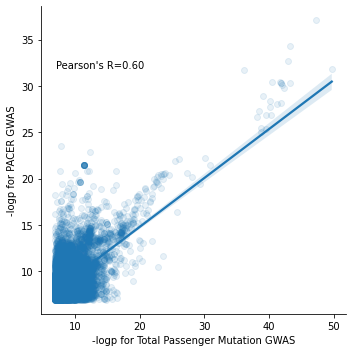

In [15]:
# compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_pacerint_df, 
#                   "-logp for Total Passenger Mutation GWAS", "-logp for PACER GWAS")

## Zekavat et al

Our GWAS was for clonal expansion rate, Zekavat et al did a GWAS for expanded clones (clonal fraction > 10%) 
https://www.nature.com/articles/s41591-021-01371-0#Sec20

This section looks at their significant SNPs and plots our p-values for the same SNPs.

In [13]:
!gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_hits_mcasexpandedclones.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_hits_mcasexpandedclones.csv...
/ [1 files][  8.6 KiB/  8.6 KiB]                                                
Operation completed over 1 objects/8.6 KiB.                                      


In [14]:
# Importing and processing SNP df
gwas_results_expandedclone_df = pd.read_csv('gwas_hits_mcasexpandedclones.csv')
gwas_results_expandedclone_df.rename(columns={"rsid": "SNPID", "P": "p.value"}, inplace=True)
gwas_results_expandedclone_df['-logp'] = -np.log(gwas_results_expandedclone_df['p.value'])

In [15]:
compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_expandedclone_df,
                   "-logp for Total Passenger Mutation GWAS", "-logp for PACER GWAS")

63 hits for expanded clones
2 SNPs with p-values in both datasets


In [16]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_summary_stats_mcasexpandedclones.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_summary_stats_mcasexpandedclones.csv...
- [1 files][753.7 MiB/753.7 MiB]   40.8 MiB/s                                   
Operation completed over 1 objects/753.7 MiB.                                    


In [17]:
# Importing and processing SNP df
gwas_summarystats_expandedclone_df = pd.read_csv('gwas_summary_stats_mcasexpandedclones.csv', sep ='\t')
gwas_summarystats_expandedclone_df.rename(columns={"rsid": "SNPID", "neg_log_pvalue": "-logp"}, inplace=True)

In [18]:
def manhattanplot_expandedclone(df, gwas_results_totpassmut_df):
    running_pos = 0
    cumulative_pos = []
    for chrom, group_df in df.groupby('#chrom'):  
        cumulative_pos.append(group_df['pos'] + running_pos)
        running_pos += group_df['pos'].max()
    df['cumulative_pos'] = pd.concat(cumulative_pos)
    df['SNP number'] = df.index
    df['significant'] = False
    df[df['SNP number'].isin(compare_gwas_hits_expandedclone(df, gwas_results_totpassmut_df))]['significant'] = True
    palette ={True: "red", False: "gray"}
    g = sns.relplot(
        data = df,
        x = 'cumulative_pos',
        y = '-logp',
        aspect = 4,
        hue = 'significant',
        palette = palette,
        linewidth=0,
        s=6,
        legend=None
    )
    g.ax.set_ylabel('-log(p)', fontsize=20)
    g.ax.set_xlabel('Chromosome', fontsize=20)
    g.ax.set_xticks(df.groupby('#chrom')['cumulative_pos'].median())
    g.ax.set_xticklabels(df['#chrom'].unique(), fontsize=12)
    g.fig.suptitle('Manhattan Plot for GWAS of Clonal Fraction for pts with mCAs - Zekavat et al', fontsize=30)
    g.fig.set_size_inches(18.5, 10.5)
    
    
def compare_gwas_hits_expandedclone(our_df, other_df):
    our_df = our_df[['SNPID', '-logp']]
    other_df = other_df[['SNPID', '-logp']]
    other_df_hits = set(other_df['SNPID'])
    print(str(len(other_df_hits)) + " hits for total passenger mutations")
    overlap_df = our_df[our_df['SNPID'].isin(other_df_hits)]
    print(str(len(overlap_df)) + " SNPs with p-values in both datasets")
    overlap_set = set(overlap_df['SNPID'])
    our_df = our_df[our_df['SNPID'].isin(overlap_set)]
    our_df_sig = our_df[our_df['-logp'] > 20]
    return set(our_df_sig['SNPID'])

26806 hits for total passenger mutations
439719 SNPs with p-values in both datasets


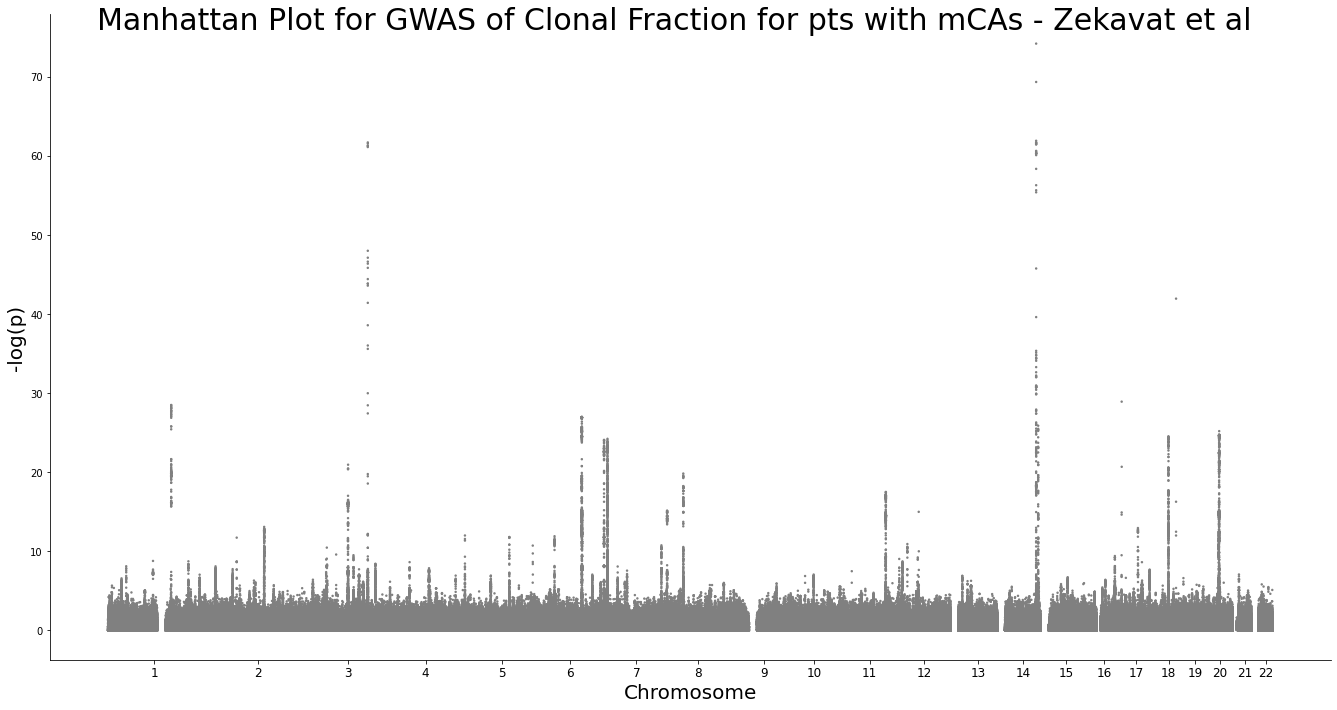

In [19]:
manhattanplot_expandedclone(gwas_summarystats_expandedclone_df, gwas_results_totpassmut_df)

10394968 hits for expanded clones
12837 SNPs with p-values in both datasets


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


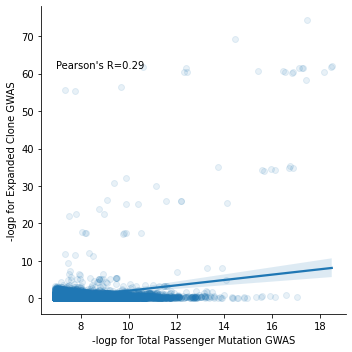

In [20]:
compare_gwas_hits(gwas_results_totpassmut_df, gwas_summarystats_expandedclone_df,
                   "-logp for Total Passenger Mutation GWAS", "-logp for Expanded Clone GWAS")

,CHR,POS,SNPID,Allele1,Allele2,AC_Allele2,AF_Allele2,imputationInfo,N,BETA,SE,Tstat,p.value,varT,varTstar,-logp,cumulative_pos,SNP number
0,chr1,817372,rs143872709,C,T,134,0.002620,1,25570,0.293822,0.078266,47.966048,0.000174,163.248651,131.786153,8.656768,817372,0
1,chr1,829571,rs180676202,A,T,134,0.002620,1,25570,0.293822,0.078266,47.966048,0.000174,163.248651,131.786153,8.656768,829571,1
2,chr1,836636,rs142814434,G,A,134,0.002620,1,25570,0.293822,0.078266,47.966048,0.000174,163.248651,131.786153,8.656768,836636,2
3,chr1,843766,rs140464834,G,C,274,0.005358,1,25570,0.206275,0.054797,68.695881,0.000167,333.030278,268.846198,8.697579,843766,3
4,chr1,846197,rs148585719,C,T,650,0.012710,1,25570,0.120675,0.035985,93.190641,0.000798,772.242329,623.410026,7.133368,846197,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44561,chr22,50232926,rs190695755,G,A,102,0.001995,1,25570,0.301273,0.089267,37.807188,0.000738,125.491642,101.305957,7.211162,1687909948,44561
44562,chr22,50451788,rs890201477,G,A,71,0.001388,1,25570,0.367969,0.106861,32.223723,0.000574,87.571869,70.694365,7.462273,1688128810,44562
44563,chr22,50462208,rs199705951,T,C,94,0.001838,1,25570,0.324123,0.093277,37.252770,0.000511,114.933932,92.783007,7.578820,1688139230,44563
44564,chr22,50497937,rs147544240,C,T,471,0.009210,1,25570,-0.143605,0.042010,-81.369198,0.000630,566.616421,457.413877,7.369727,1688174959,44564


## Coronary Artery Disease from GWAS Catalog

In [ ]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas-association-downloaded_2022-08-08-EFO_1000883-withChildTraits.tsv .

In [ ]:
# gwas_results_cad_df = pd.read_csv('gwas-association-downloaded_2022-08-08-EFO_1000883-withChildTraits.tsv',
#             sep='\t', on_bad_lines='skip')

In [ ]:
# gwas_results_cad_df.columns
# gwas_results_cad_df.rename(columns={"SNPS": "SNPID", "P-VALUE": "p.value"}, inplace=True)
# gwas_results_cad_df['-logp'] = -np.log(gwas_results_cad_df['p.value'])

In [ ]:
# compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_cad_df,
#                    "-logp for Total Passenger Mutation GWAS", "-logp for Coronary Artery Disease")

## CLL from GWAS Catalog

In [ ]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas-association-downloaded_2022-08-08-EFO_0000095.tsv .

In [ ]:
# gwas_results_cll_df = pd.read_csv('gwas-association-downloaded_2022-08-08-EFO_0000095.tsv',
#             sep='\t', on_bad_lines='skip')

In [ ]:
# gwas_results_cll_df.rename(columns={"SNPS": "SNPID", "P-VALUE": "p.value"}, inplace=True)
# gwas_results_cll_df['-logp'] = -np.log(gwas_results_cll_df['p.value'])

In [ ]:
# compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_cll_df,
#                    "-logp for Total Passenger Mutation GWAS", "-logp for Chronic Lymphocytic Leukemia")

## Mosaic loss of Y from GWAS Catalog

In [ ]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas-association-downloaded_2022-08-08-EFO_0007783.tsv .

In [ ]:
# gwas_results_mloy_df = pd.read_csv('gwas-association-downloaded_2022-08-08-EFO_0007783.tsv',
#             sep='\t', on_bad_lines='skip')

In [ ]:
# gwas_results_mloy_df.rename(columns={"SNPS": "SNPID", "P-VALUE": "p.value"}, inplace=True)
# gwas_results_mloy_df['-logp'] = -np.log(gwas_results_mloy_df['p.value'])

In [ ]:
compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_mloy_df,
#                    "-logp for Total Passenger Mutation GWAS", "-logp for mLOY")